<a href="https://colab.research.google.com/github/idax6797/DeepLearning-MiniProject/blob/main/UNet2Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


# Unet++ Architecture

In [68]:
#Define the Convolutional Block
class ConvoBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [69]:
#Define the UNet++ Architecture
class UnetPlusPlus(nn.Module):
    def __init__(self, in_channels: int =1, num_classes: int = 2, deep_supervision: bool = False, base_filters: int = 32):
        super(UnetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        #Filters sizes at each level
        filters = [base_filters * (2 ** i) for i in range(5)]

        #Encoder - Downsampling path
        self.conv0_0 = ConvoBlock(in_channels, filters[0])
        self.conv1_0 = ConvoBlock(filters[0], filters[1])
        self.conv2_0 = ConvoBlock(filters[1], filters[2])
        self.conv3_0 = ConvoBlock(filters[2], filters[3])
        self.conv4_0 = ConvoBlock(filters[3], filters[4])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Dense Decoder
        self.conv0_1 = ConvoBlock(filters[0] + filters[1], filters[0])
        self.conv0_2 = ConvoBlock(filters[0] * 2 + filters[1], filters[0])
        self.conv0_3 = ConvoBlock(filters[0] * 3 + filters[1], filters[0])
        self.conv0_4 = ConvoBlock(filters[0] * 4 + filters[1], filters[0])

        #Level 1 dense connections
        self.conv1_1 = ConvoBlock(filters[1] + filters[2], filters[1])
        self.conv1_2 = ConvoBlock(filters[1] * 2 + filters[2], filters[1])
        self.conv1_3 = ConvoBlock(filters[1] * 3 + filters[2], filters[1])

        #Level 2 dense connections
        self.conv2_1 = ConvoBlock(filters[2] + filters[3], filters[2])
        self.conv2_2 = ConvoBlock(filters[2] * 2 + filters[3], filters[2])

        #Level 3 dense connections
        self.conv3_1 = ConvoBlock(filters[3] + filters[4], filters[3])


        #Upsampling Layers
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(filters[4], filters[4], kernel_size=2, stride=2)

        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)

        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)

        self.up1_3 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)


        #Output layers
        if self.deep_supervision:
            self.final1 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
            #Encoder path
            x0_0 = self.conv0_0(x)
            x1_0 = self.conv1_0(self.pool(x0_0))
            x2_0 = self.conv2_0(self.pool(x1_0))
            x3_0 = self.conv3_0(self.pool(x2_0))
            x4_0 = self.conv4_0(self.pool(x3_0))

            #Decoder path with dense connections
            x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], dim=1))
            x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], dim=1))
            x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], dim=1))
            x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], dim=1))

            x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], dim=1))
            x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], dim=1))
            x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], dim=1))

            x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], dim=1))
            x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], dim=1))

            x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], dim=1))

            #Output
            if self.deep_supervision:
                output1 = self.final1(x0_1)
                output2 = self.final2(x0_2)
                output3 = self.final3(x0_3)
                output4 = self.final4(x0_4)
                return [output1 + output2 + output3 + output4]
            else:
                return self.final(x0_4)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [70]:
#Initialize model
unetpp = UnetPlusPlus(in_channels=1, num_classes=1, deep_supervision=False, base_filters=32).to(device)
num_params = unetpp.count_parameters()
print(f"Number of trainable parameters in UNet++: {num_params}")

Number of trainable parameters in UNet++: 10999425


# Dice Coefficient Function & IoU Function


In [6]:
class BCEDiceLoss(nn.Module):
    """BCE + Dice Loss for binary segmentation (num_classes = 1)"""
    def __init__(self, smooth=1.0, bce_weight=0.5):
        """
        smooth: stabilizer to avoid division by zero
        bce_weight: balance between BCE and Dice (0–1)
        """
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth
        self.bce_weight = bce_weight

    def forward(self, logits, target):
        # BCEWithLogitsLoss expects raw logits (no sigmoid)
        bce = self.bce(logits, target)

        # Dice part
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        target = target.view(-1)
        intersection = (probs * target).sum()
        dice = (2.0 * intersection + self.smooth) / (probs.sum() + target.sum() + self.smooth)
        dice_loss = 1 - dice

        # Weighted sum
        return self.bce_weight * bce + (1 - self.bce_weight) * dice_loss

In [7]:
def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()

    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()

In [8]:
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    iou = intersection / (union + epsilon)
    return iou.item()

# Training Setup


In [71]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.Adam(unetpp.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: BCE for segmentation
seg_criterion = nn.BCEWithLogitsLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: BCE (Binary Cross-Entropy)")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: BCE (Binary Cross-Entropy)
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


In [72]:
def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        if isinstance(outputs, list):
            # Deep supervision
            losses = [seg_criterion(o, masks) for o in outputs]
            loss = sum(losses) / len(losses)
            seg_logits = outputs[-1]
        else:
            seg_logits = outputs
            loss = seg_criterion(seg_logits, masks)

        # Compute loss
        # loss = seg_criterion(seg_logits, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        seg_probs = torch.sigmoid(seg_logits)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)

        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)

        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })

    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


In [73]:
def validate_epoch(model, dataloader, epoch):
    model.eval()
    val_loss, val_dice, val_iou = [], [], []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if isinstance(outputs, list):
                losses = [seg_criterion(o, masks) for o in outputs]
                loss = sum(losses) / len(losses)
                seg_logits = outputs[-1]
            else:
                seg_logits = outputs
                loss = seg_criterion(seg_logits, masks)

            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)

            val_loss.append(loss.item())
            val_dice.append(dice)
            val_iou.append(iou)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "dice": f"{dice:.4f}",
                "iou": f"{iou:.4f}"
            })

    return {
        "loss": np.mean(val_loss),
        "dice": np.mean(val_dice),
        "iou": np.mean(val_iou)
    }

# Load data

In [12]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split

        print(f"\n{'='*70}")
        print("Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")

        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")

        self.samples = []

        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'

        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")

        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))

        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")

            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem

                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]

                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break

                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1

            print(f"  Matched {matched} patient images with labels")

        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])

        print(f"\n{'='*70}")
        print(f"{split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")

        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")

    def __len__(self):
        return len(self.samples)

    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)

    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]

        image = self._load_image(img_path)

        if image.max() > 1.0:
            image = image / 255.0

        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)

        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]

        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)

        return image, mask, clf_label


print("="*70)
print("LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/content/drive/MyDrive/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\nChecking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()

        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")

        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")

LOADING PRE-SPLIT MIP-PET TUMOR DATASET

Checking: /content/drive/MyDrive/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

Final data directory: /content/drive/MyDrive/preprocessed_data


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

VAL SET SUMMARY
  Controls: 64
  Patients: 27
  Total: 91
  Tumor ratio: 29.7%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 28 patient ima

# Train the Model

In [74]:
import time
training_start = time.time()
best_val_dice = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Train
    train_metrics = train_epoch(unetpp, train_loader, optimizer, epoch)

    # Validate
    val_metrics = validate_epoch(unetpp, val_loader, epoch)

    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])

    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)

    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(unetpp.state_dict(), 'best_unet_segmentation.pth')
        print(f"  ✓ New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
unetpp.load_state_dict(torch.load('best_unet_segmentation.pth'))
print("\n✓ Best model loaded for evaluation!")

Epoch 1 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.4329, dice=0.0077, iou=0.0039]



Epoch 1/50 Summary:
  Train - Loss: 0.4793, Dice: 0.0440, IoU: 0.0234
  Val   - Loss: 0.4244, Dice: 0.0008, IoU: 0.0004
  Time: 40.9s
  ✓ New best model saved! (Dice: 0.0008)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s, loss=0.3831, dice=0.1064, iou=0.0562]



Epoch 2/50 Summary:
  Train - Loss: 0.3877, Dice: 0.0075, IoU: 0.0038
  Val   - Loss: 0.3730, Dice: 0.0119, IoU: 0.0062
  Time: 39.5s
  ✓ New best model saved! (Dice: 0.0119)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.3636, dice=0.1469, iou=0.0793]



Epoch 3/50 Summary:
  Train - Loss: 0.3561, Dice: 0.1001, IoU: 0.0580
  Val   - Loss: 0.3472, Dice: 0.0618, IoU: 0.0350
  Time: 40.1s
  ✓ New best model saved! (Dice: 0.0618)


Epoch 4 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, loss=0.3302, dice=0.0524, iou=0.0269]



Epoch 4/50 Summary:
  Train - Loss: 0.3309, Dice: 0.2021, IoU: 0.1286
  Val   - Loss: 0.3218, Dice: 0.0353, IoU: 0.0192
  Time: 40.0s


Epoch 5 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s, loss=0.3174, dice=0.5465, iou=0.3759]



Epoch 5/50 Summary:
  Train - Loss: 0.3081, Dice: 0.3170, IoU: 0.2123
  Val   - Loss: 0.3024, Dice: 0.1965, IoU: 0.1397
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.1965)


Epoch 6 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.2921, dice=0.3370, iou=0.2027]



Epoch 6/50 Summary:
  Train - Loss: 0.2884, Dice: 0.2112, IoU: 0.1483
  Val   - Loss: 0.2819, Dice: 0.0977, IoU: 0.0584
  Time: 40.1s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, loss=0.2815, dice=0.4896, iou=0.3242]



Epoch 7/50 Summary:
  Train - Loss: 0.2694, Dice: 0.3950, IoU: 0.2832
  Val   - Loss: 0.2654, Dice: 0.2041, IoU: 0.1484
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.2041)


Epoch 8 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.2563, dice=0.2445, iou=0.1393]



Epoch 8/50 Summary:
  Train - Loss: 0.2526, Dice: 0.4163, IoU: 0.3012
  Val   - Loss: 0.2443, Dice: 0.1097, IoU: 0.0663
  Time: 39.9s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s, loss=0.2478, dice=0.5485, iou=0.3778]



Epoch 9/50 Summary:
  Train - Loss: 0.2369, Dice: 0.4643, IoU: 0.3404
  Val   - Loss: 0.2338, Dice: 0.2089, IoU: 0.1531
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.2089)


Epoch 10 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.2331, dice=0.5042, iou=0.3371]



Epoch 10/50 Summary:
  Train - Loss: 0.2225, Dice: 0.4646, IoU: 0.3512
  Val   - Loss: 0.2194, Dice: 0.2093, IoU: 0.1540
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.2093)


Epoch 11 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s, loss=0.2275, dice=0.5756, iou=0.4041]



Epoch 11/50 Summary:
  Train - Loss: 0.2098, Dice: 0.4894, IoU: 0.3668
  Val   - Loss: 0.2176, Dice: 0.1928, IoU: 0.1359
  Time: 40.1s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, loss=0.2072, dice=0.4661, iou=0.3038]



Epoch 12/50 Summary:
  Train - Loss: 0.1989, Dice: 0.3987, IoU: 0.2850
  Val   - Loss: 0.1938, Dice: 0.1998, IoU: 0.1442
  Time: 39.9s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.1895, dice=0.5349, iou=0.3651]



Epoch 13/50 Summary:
  Train - Loss: 0.1855, Dice: 0.4724, IoU: 0.3536
  Val   - Loss: 0.1779, Dice: 0.2018, IoU: 0.1453
  Time: 39.8s


Epoch 14 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.1832, dice=0.2127, iou=0.1190]



Epoch 14/50 Summary:
  Train - Loss: 0.1744, Dice: 0.5216, IoU: 0.3955
  Val   - Loss: 0.1692, Dice: 0.0766, IoU: 0.0442
  Time: 39.9s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s, loss=0.1732, dice=0.3779, iou=0.2329]



Epoch 15/50 Summary:
  Train - Loss: 0.1641, Dice: 0.5271, IoU: 0.4016
  Val   - Loss: 0.1603, Dice: 0.1477, IoU: 0.0979
  Time: 39.8s


Epoch 16 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s, loss=0.1677, dice=0.5529, iou=0.3821]



Epoch 16/50 Summary:
  Train - Loss: 0.1549, Dice: 0.5558, IoU: 0.4315
  Val   - Loss: 0.1528, Dice: 0.2247, IoU: 0.1711
  Time: 39.8s
  ✓ New best model saved! (Dice: 0.2247)


Epoch 17 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.1581, dice=0.5473, iou=0.3768]



Epoch 17/50 Summary:
  Train - Loss: 0.1456, Dice: 0.6039, IoU: 0.4743
  Val   - Loss: 0.1447, Dice: 0.2117, IoU: 0.1562
  Time: 39.9s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.1529, dice=0.1680, iou=0.0917]



Epoch 18/50 Summary:
  Train - Loss: 0.1375, Dice: 0.5882, IoU: 0.4595
  Val   - Loss: 0.1373, Dice: 0.0755, IoU: 0.0439
  Time: 39.9s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.1400, dice=0.3045, iou=0.1796]



Epoch 19/50 Summary:
  Train - Loss: 0.1296, Dice: 0.5645, IoU: 0.4461
  Val   - Loss: 0.1252, Dice: 0.1826, IoU: 0.1306
  Time: 39.9s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.1307, dice=0.5499, iou=0.3793]



Epoch 20/50 Summary:
  Train - Loss: 0.1226, Dice: 0.6145, IoU: 0.4865
  Val   - Loss: 0.1194, Dice: 0.2067, IoU: 0.1504
  Time: 39.9s


Epoch 21 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.1448, dice=0.5169, iou=0.3485]



Epoch 21/50 Summary:
  Train - Loss: 0.1155, Dice: 0.6274, IoU: 0.4995
  Val   - Loss: 0.1198, Dice: 0.2014, IoU: 0.1453
  Time: 39.9s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.1219, dice=0.5175, iou=0.3491]



Epoch 22/50 Summary:
  Train - Loss: 0.1089, Dice: 0.6359, IoU: 0.5094
  Val   - Loss: 0.1081, Dice: 0.1987, IoU: 0.1423
  Time: 39.8s


Epoch 23 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.1207, dice=0.3372, iou=0.2028]



Epoch 23/50 Summary:
  Train - Loss: 0.1036, Dice: 0.5640, IoU: 0.4431
  Val   - Loss: 0.1035, Dice: 0.1872, IoU: 0.1345
  Time: 39.9s


Epoch 24 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.1046, dice=0.6928, iou=0.5299]



Epoch 24/50 Summary:
  Train - Loss: 0.0975, Dice: 0.6596, IoU: 0.5308
  Val   - Loss: 0.0956, Dice: 0.2222, IoU: 0.1670
  Time: 39.9s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, loss=0.1059, dice=0.5229, iou=0.3540]



Epoch 25/50 Summary:
  Train - Loss: 0.0933, Dice: 0.5690, IoU: 0.4368
  Val   - Loss: 0.0924, Dice: 0.2059, IoU: 0.1507
  Time: 39.9s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.61it/s, loss=0.1062, dice=0.5280, iou=0.3587]



Epoch 26/50 Summary:
  Train - Loss: 0.0877, Dice: 0.6406, IoU: 0.5186
  Val   - Loss: 0.0903, Dice: 0.2288, IoU: 0.1767
  Time: 39.8s
  ✓ New best model saved! (Dice: 0.2288)


Epoch 27 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.0982, dice=0.4598, iou=0.2985]



Epoch 27/50 Summary:
  Train - Loss: 0.0835, Dice: 0.6398, IoU: 0.5113
  Val   - Loss: 0.0831, Dice: 0.2044, IoU: 0.1507
  Time: 40.1s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s, loss=0.0948, dice=0.6397, iou=0.4703]



Epoch 28/50 Summary:
  Train - Loss: 0.0793, Dice: 0.7043, IoU: 0.5834
  Val   - Loss: 0.0797, Dice: 0.2352, IoU: 0.1822
  Time: 39.8s
  ✓ New best model saved! (Dice: 0.2352)


Epoch 29 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, loss=0.0868, dice=0.6738, iou=0.5080]



Epoch 29/50 Summary:
  Train - Loss: 0.0760, Dice: 0.6020, IoU: 0.4795
  Val   - Loss: 0.0750, Dice: 0.2377, IoU: 0.1849
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.2377)


Epoch 30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s, loss=0.0885, dice=0.3249, iou=0.1939]



Epoch 30/50 Summary:
  Train - Loss: 0.0713, Dice: 0.6873, IoU: 0.5620
  Val   - Loss: 0.0717, Dice: 0.1465, IoU: 0.0953
  Time: 39.9s


Epoch 31 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s, loss=0.0797, dice=0.5083, iou=0.3407]



Epoch 31/50 Summary:
  Train - Loss: 0.0682, Dice: 0.7069, IoU: 0.5823
  Val   - Loss: 0.0662, Dice: 0.2011, IoU: 0.1455
  Time: 39.7s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, loss=0.0759, dice=0.6924, iou=0.5295]



Epoch 32/50 Summary:
  Train - Loss: 0.0643, Dice: 0.6493, IoU: 0.5319
  Val   - Loss: 0.0639, Dice: 0.2350, IoU: 0.1822
  Time: 39.7s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0689, dice=0.7650, iou=0.6195]



Epoch 33/50 Summary:
  Train - Loss: 0.0609, Dice: 0.7498, IoU: 0.6302
  Val   - Loss: 0.0616, Dice: 0.2478, IoU: 0.1976
  Time: 39.9s
  ✓ New best model saved! (Dice: 0.2478)


Epoch 34 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0729, dice=0.5823, iou=0.4108]



Epoch 34/50 Summary:
  Train - Loss: 0.0585, Dice: 0.7543, IoU: 0.6318
  Val   - Loss: 0.0581, Dice: 0.2212, IoU: 0.1668
  Time: 39.8s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s, loss=0.0680, dice=0.6814, iou=0.5168]



Epoch 35/50 Summary:
  Train - Loss: 0.0553, Dice: 0.7316, IoU: 0.6137
  Val   - Loss: 0.0565, Dice: 0.2375, IoU: 0.1851
  Time: 39.8s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.0624, dice=0.7084, iou=0.5484]



Epoch 36/50 Summary:
  Train - Loss: 0.0524, Dice: 0.7877, IoU: 0.6660
  Val   - Loss: 0.0534, Dice: 0.2110, IoU: 0.1556
  Time: 39.7s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0687, dice=0.5403, iou=0.3702]



Epoch 37/50 Summary:
  Train - Loss: 0.0504, Dice: 0.7101, IoU: 0.5845
  Val   - Loss: 0.0522, Dice: 0.1877, IoU: 0.1311
  Time: 39.9s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, loss=0.0627, dice=0.6024, iou=0.4311]



Epoch 38/50 Summary:
  Train - Loss: 0.0478, Dice: 0.6890, IoU: 0.5807
  Val   - Loss: 0.0499, Dice: 0.2230, IoU: 0.1687
  Time: 40.0s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.61it/s, loss=0.0593, dice=0.6632, iou=0.4962]



Epoch 39/50 Summary:
  Train - Loss: 0.0452, Dice: 0.7245, IoU: 0.6088
  Val   - Loss: 0.0475, Dice: 0.2242, IoU: 0.1704
  Time: 39.9s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s, loss=0.0683, dice=0.6162, iou=0.4453]



Epoch 40/50 Summary:
  Train - Loss: 0.0435, Dice: 0.6828, IoU: 0.5706
  Val   - Loss: 0.0463, Dice: 0.2386, IoU: 0.1868
  Time: 39.9s


Epoch 41 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s, loss=0.0595, dice=0.6325, iou=0.4625]



Epoch 41/50 Summary:
  Train - Loss: 0.0413, Dice: 0.7548, IoU: 0.6463
  Val   - Loss: 0.0434, Dice: 0.2440, IoU: 0.1935
  Time: 39.9s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.0523, dice=0.6449, iou=0.4759]



Epoch 42/50 Summary:
  Train - Loss: 0.0390, Dice: 0.7470, IoU: 0.6422
  Val   - Loss: 0.0402, Dice: 0.2242, IoU: 0.1703
  Time: 39.9s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s, loss=0.0581, dice=0.2677, iou=0.1546]



Epoch 43/50 Summary:
  Train - Loss: 0.0374, Dice: 0.7716, IoU: 0.6623
  Val   - Loss: 0.0399, Dice: 0.1620, IoU: 0.1100
  Time: 40.0s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0553, dice=0.6284, iou=0.4581]



Epoch 44/50 Summary:
  Train - Loss: 0.0357, Dice: 0.7765, IoU: 0.6587
  Val   - Loss: 0.0386, Dice: 0.2421, IoU: 0.1912
  Time: 39.9s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0443, dice=0.7463, iou=0.5952]



Epoch 45/50 Summary:
  Train - Loss: 0.0342, Dice: 0.7715, IoU: 0.6671
  Val   - Loss: 0.0360, Dice: 0.2402, IoU: 0.1885
  Time: 39.9s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s, loss=0.0478, dice=0.6109, iou=0.4398]



Epoch 46/50 Summary:
  Train - Loss: 0.0326, Dice: 0.7484, IoU: 0.6431
  Val   - Loss: 0.0357, Dice: 0.1981, IoU: 0.1428
  Time: 40.0s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.0413, dice=0.7202, iou=0.5628]



Epoch 47/50 Summary:
  Train - Loss: 0.0314, Dice: 0.7626, IoU: 0.6484
  Val   - Loss: 0.0331, Dice: 0.2261, IoU: 0.1721
  Time: 40.1s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0401, dice=0.7654, iou=0.6200]



Epoch 48/50 Summary:
  Train - Loss: 0.0298, Dice: 0.7812, IoU: 0.6815
  Val   - Loss: 0.0318, Dice: 0.2427, IoU: 0.1917
  Time: 39.9s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s, loss=0.0429, dice=0.6859, iou=0.5219]



Epoch 49/50 Summary:
  Train - Loss: 0.0284, Dice: 0.8015, IoU: 0.7006
  Val   - Loss: 0.0314, Dice: 0.2329, IoU: 0.1793
  Time: 39.8s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s, loss=0.0441, dice=0.6976, iou=0.5356]


Epoch 50/50 Summary:
  Train - Loss: 0.0271, Dice: 0.7815, IoU: 0.6901
  Val   - Loss: 0.0303, Dice: 0.2443, IoU: 0.1931
  Time: 40.1s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 1996.9s (33.3 minutes)
Average epoch time: 39.9s
Best validation Dice: 0.2478

✓ Best model loaded for evaluation!


# Visualization

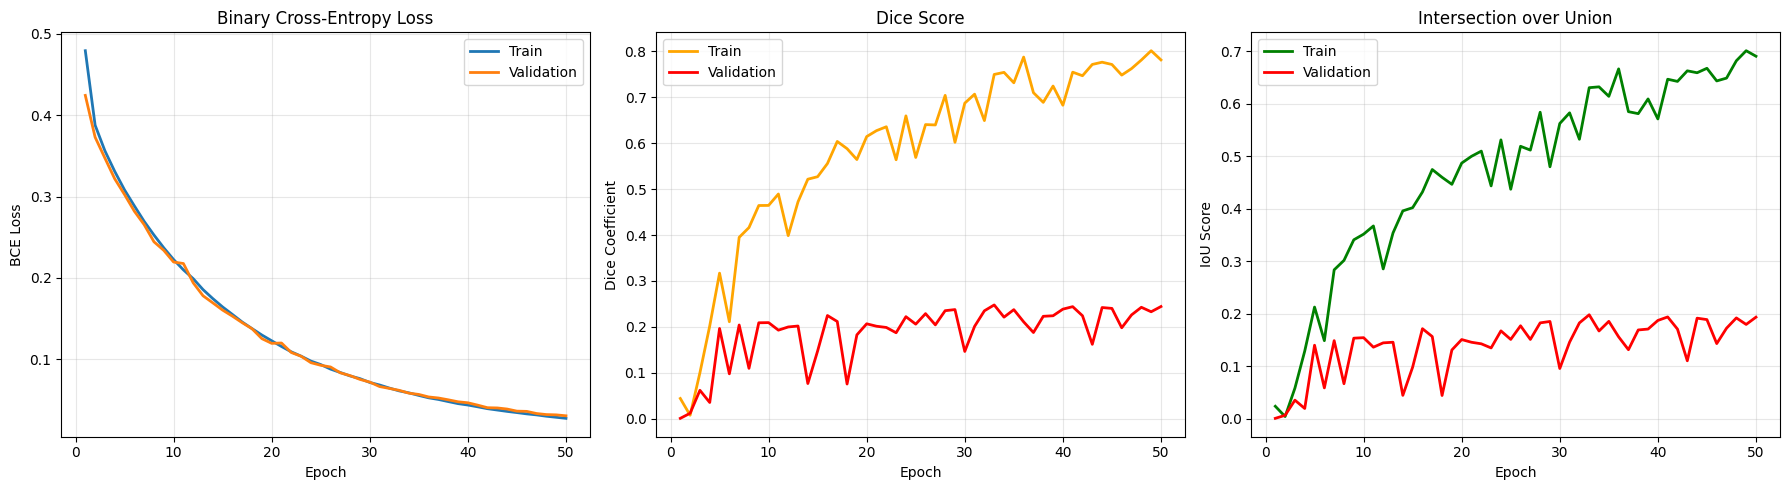

In [75]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # BCE Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE Loss')
    axes[0].set_title('Binary Cross-Entropy Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Classification from Segmentation Masks

In [76]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):

    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)


    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [77]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)
            seg_probs = torch.sigmoid(seg_logits)

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.6053
  IoU Score: 0.4340
  BCE Loss: 0.0645
  Pixel Accuracy: 0.9966
  Sensitivity (Recall): 0.6875
  Specificity: 0.9978
  Precision: 0.5407

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.7717
  Precision: 0.5745
  Recall: 0.9643
  F1-Score: 0.7200

  Per-Sample Metrics:
    Mean Dice: 0.1936
    Mean IoU: 0.1568

  Average Dice by Classification:
    True Positives (TP): 0.6596
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


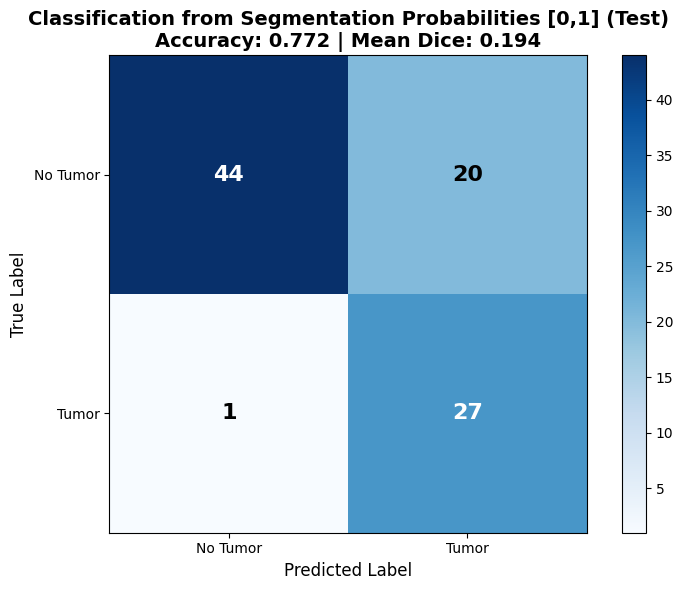

In [78]:
#Evaluate on test set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    unetpp, test_loader, split_name="Test"
)

# Show predictions


In [79]:
#Inspect what the loader yields
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))


<class 'list'>
3


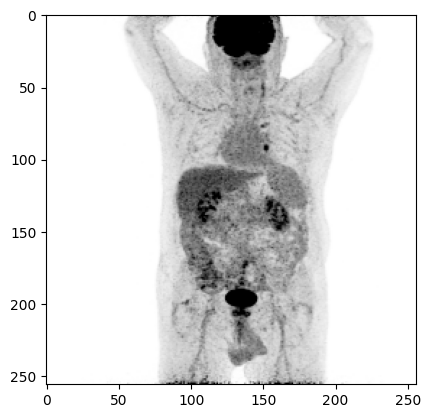

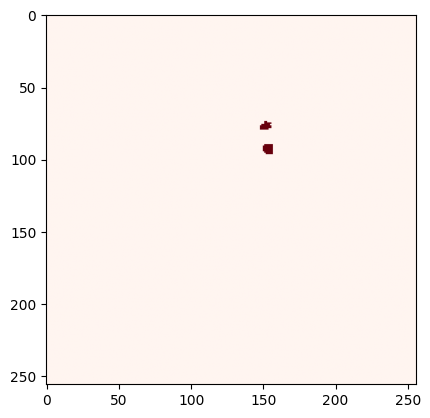

In [80]:
# Display image and label.
train_features, train_labels, _ = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

In [81]:
def predict(model, image, device):
    model.eval()

    # Ensure correct shape
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dim

    image = image.to(device)

    with torch.no_grad():
        output = model(image)

        # Get final output if deep supervision
        if isinstance(output, list):
            output = output[-1]

        # Get probabilities
        probs = torch.sigmoid(output)
        tumor_prob = probs
        pred_mask = (tumor_prob > 0.5).float()

    return pred_mask.squeeze().cpu(), tumor_prob.squeeze().cpu()

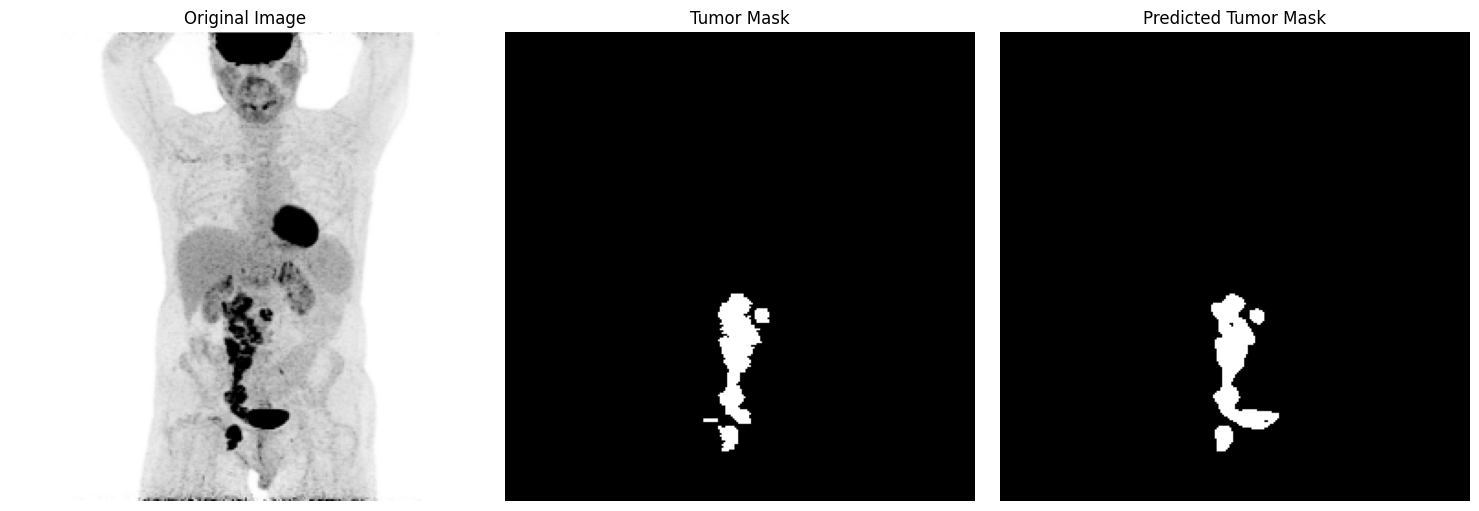

In [86]:
train_features, train_labels, _ = next(iter(train_loader))

pred_mask, _ = predict(unetpp, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()